In [16]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
from scipy import stats
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

from collections import Counter 

%config InlineBackend.figure_format = 'retina'
plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])

### binomial distribution update

prior

In [9]:
grid_points = 200
p_grid = np.linspace(0, 1, grid_points)
prior = np.repeat(1, grid_points)  # uniform density

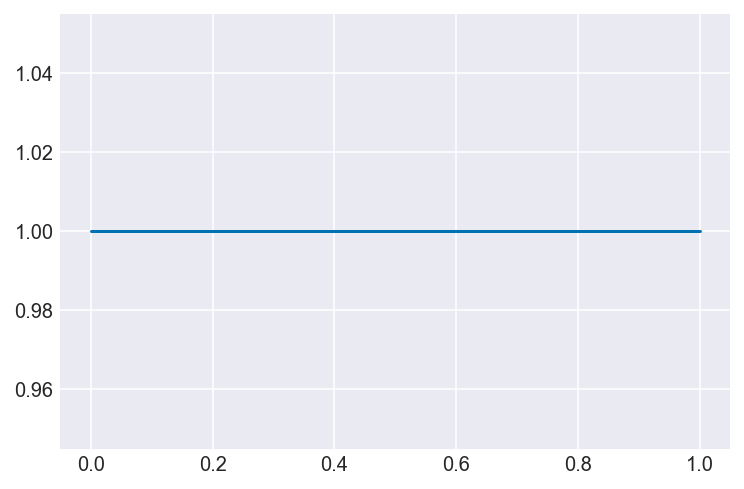

In [21]:
plt.plot(p_grid, prior)

### sampling distribution methods

In [17]:
def sample_bernoulli(n, p):
    return np.sum([np.random.binomial(1, p) for i in range(n)])

# slow...
def binomial_pdf(ks, n, p, simulations=1000):
    "simulation approach to get binom.pdf"
    
    # Bernoulli distributino samples 
    arr = [sample_bernoulli(n, p) for num in range(simulations)]
    c = Counter(arr) 
    
    # get frequency (histogram) then normalize to get the density
    prob = [c[k]/simulations for k in range(n+1)]
    if isinstance(ks, list):
        return [prob[k] for k in ks ]
    else:
        return prob[ks]
    

In [18]:
likelihood = [binomial_pdf(6, 9, p) for p in p_grid]

In [19]:
len(likelihood)

200

In [20]:
binomial_likelihood = stats.binom.pmf(6, 9, p_grid)

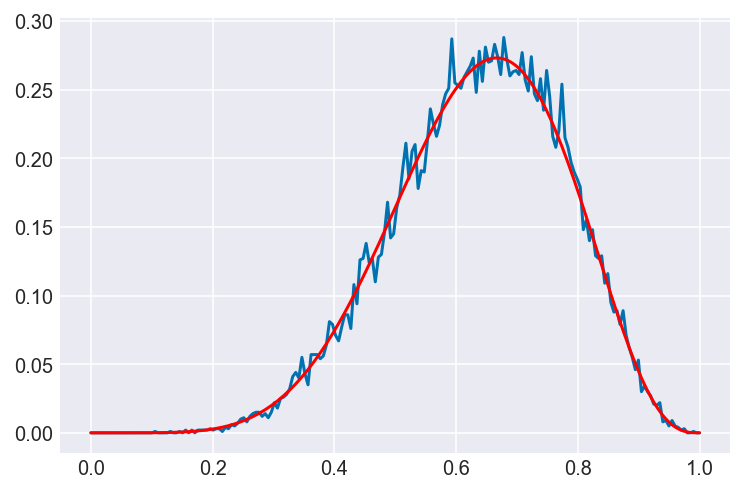

In [23]:
plt.plot(p_grid, likelihood)
plt.plot(p_grid, binomial_likelihood, 'r')

### Bayes update simulation

In [33]:
# setup
grid_points = 200
p_grid = np.linspace(0, 1, grid_points)
prior = np.repeat(1, grid_points)  # uniform density

In [41]:
def bayes_update(k, n, prior, p_grid):
    likelihood = stats.binom.pmf(k, n, p_grid)
    unstd_posterior = likelihood * prior
    posterior = unstd_posterior / unstd_posterior.sum()
    return posterior


In [42]:
posterior = bayes_update(5, 9, prior, p_grid)

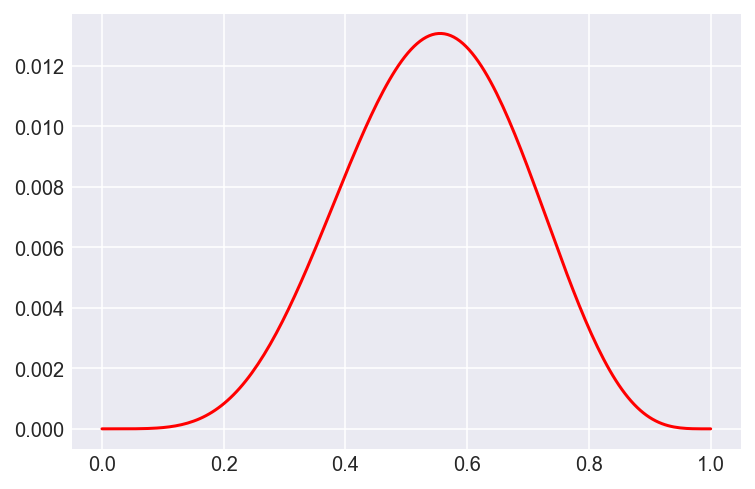

In [44]:
plt.plot(p_grid, posterior, 'r')

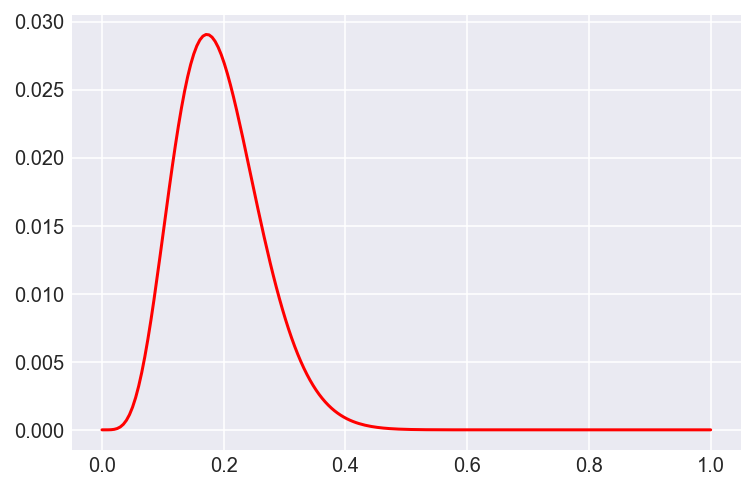

In [45]:
posterior = bayes_update(5, 29, prior, p_grid)
plt.plot(p_grid, posterior, 'r')

### Sampling approach

In [46]:
def bayes_sampling_update(k, n, prior, p_grid):
    "sampling approach"
    likelihood = [binomial_pdf(k, n, p) for p in p_grid]
#     likelihood = stats.binom.pmf(k, n, p_grid)
    unstd_posterior = likelihood * prior
    posterior = unstd_posterior / unstd_posterior.sum()
    return posterior


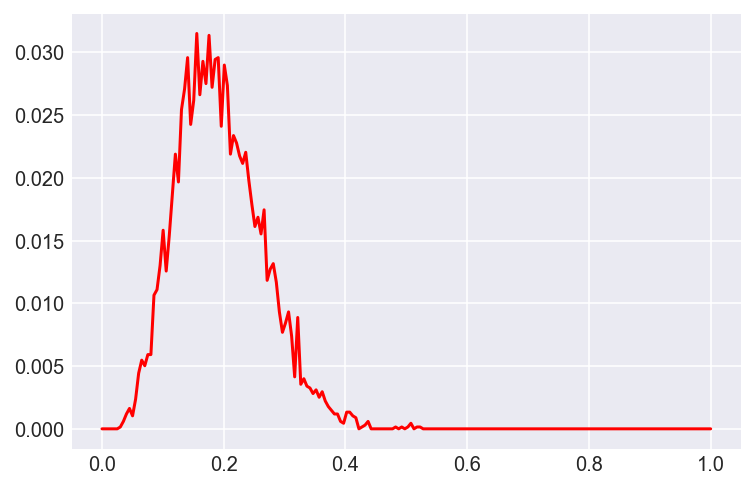

In [47]:
posterior = bayes_sampling_update(5, 29, prior, p_grid)
plt.plot(p_grid, posterior, 'r')

In [50]:
sampling_posterior = bayes_sampling_update(5, 29, prior, p_grid)
analytical_posterior = bayes_update(5, 29, prior, p_grid)

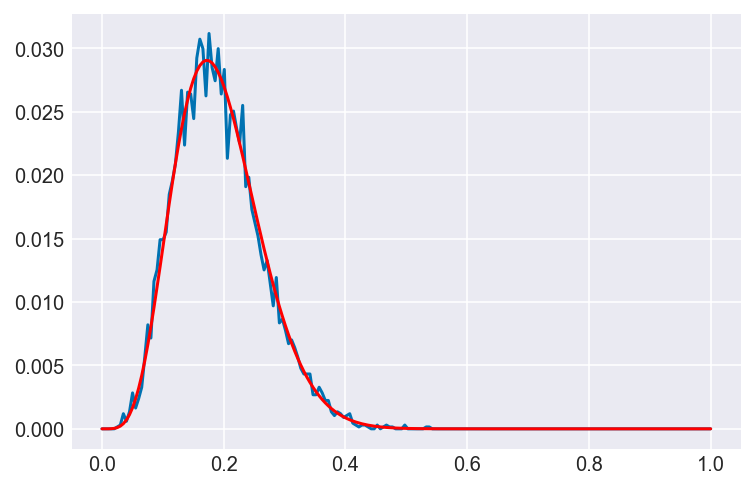

In [51]:
plt.plot(p_grid, sampling_posterior)
plt.plot(p_grid, analytical_posterior, 'r')

### Simulation

In [86]:
grid_points = 200
p_grid = np.linspace(0, 1, grid_points)
prior = np.repeat(1, grid_points)  # uniform density

In [87]:
num_simulations = 20
p = 0.7
arr = stats.bernoulli.rvs(0.7, size=num_simulations)
arr = arr.cumsum()
history = [prior]
for n in range(num_simulations):
    k = arr[n]
    n += 1
    posterior = bayes_update(k,n,prior,p_grid)
    history.append(posterior)
    prior = posterior
    

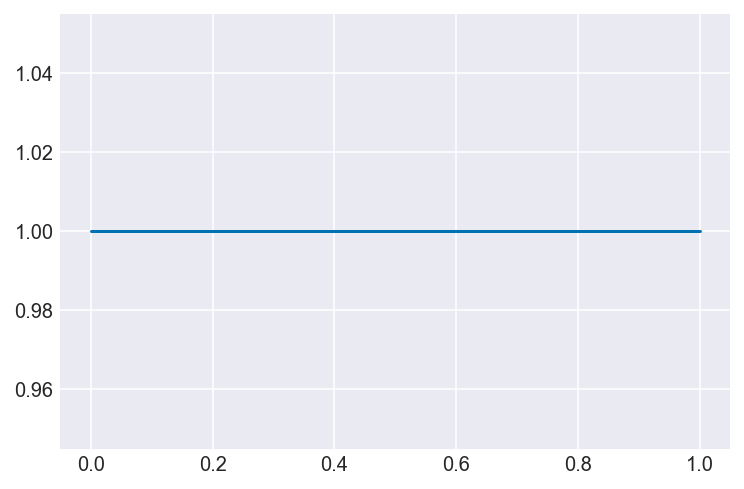

In [89]:
plt.plot(p_grid, history[0])

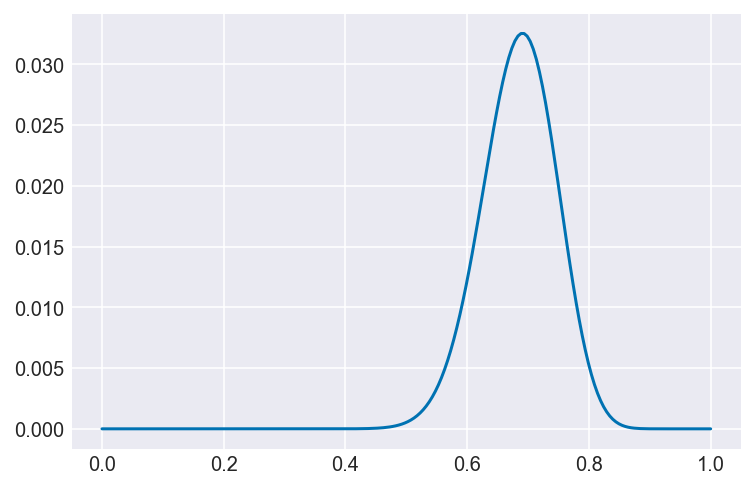

In [90]:
plt.plot(p_grid, history[10])

In [91]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

###  animate

In [138]:
class UpdateDist(object):
    def __init__(self, ax):

        # data
        self.line, = ax.plot([], [], 'k-')

        self.ax = ax

        # Set up plot parameters
        self.ax.set_xlim(0, 1)
        self.ax.set_ylim(0, 0.2)
        self.ax.grid(True)

    def setup(self, grid_points, num_simulations, p):
        # count
        self.success = 0
        self.p = p
        self.num_simulations = num_simulations
        
        #self.grid_points = grid_points
        self.x = np.linspace(0, 1, grid_points)
        self.prior = np.repeat(1, grid_points)  # uniform density
        
        # This vertical line represents the theoretical value, to
        # which the plotted distribution should converge.
        self.ax.axvline(self.p, linestyle='--', color='black')
                
        # sampling
        arr = stats.bernoulli.rvs(self.p, size=self.num_simulations)
        self.arr = arr.cumsum()
            
        # plot data
        self.line.set_data([], [])
        return self.line,

    def start(self):
        self.line.set_data([], [])
        return self.line,

    def __call__(self, i):
        
        k = self.arr[i]
        n = i + 1
        posterior = bayes_update(k, n, self.prior, self.x)
        self.prior = posterior
#         print(k, n)
        
        # update y
        self.line.set_data(self.x, posterior)
        
        return self.line,

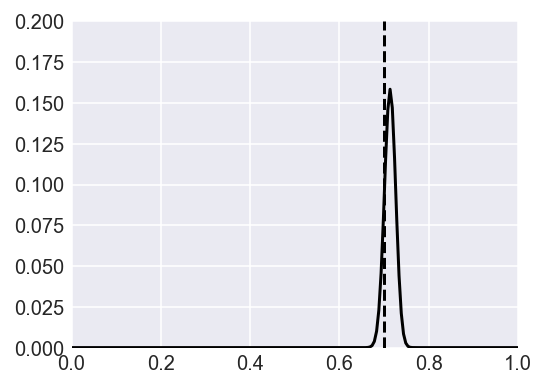

In [140]:
fig, ax = plt.subplots(figsize=(4, 3))
# theta = 0.7
ud = UpdateDist(ax)
ud.setup(200, 100, 0.7)
anim = FuncAnimation(fig, ud, frames=np.arange(50), init_func=ud.start,
                     interval=100, blit=True, repeat=False)
HTML(anim.to_html5_video())

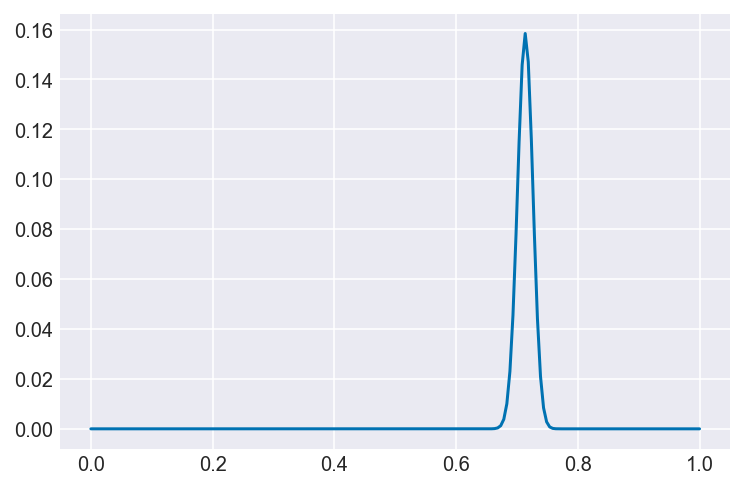

In [141]:
plt.plot(ud.x, ud.prior)